In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import math
from datetime import date
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_rows", 100, "display.max_columns", 100)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def p(s):
    print(s)
    
pd.DataFrame.len = pd.Index.len = lambda x: print(len(x))

In [2]:
# Common function definitions
def printStats(y_dev, y_pred):
    # Graph
    plt.scatter(y_dev, y_pred)
    plt.plot(y_pred,y_pred,color='black')
    plt.show()
    
    # Stats
    mae = mean_absolute_error(y_dev, y_pred).round(1)
    rmse = round(math.sqrt(mean_squared_error(y_dev, y_pred)),1)
    r2 = r2_score(y_dev, y_pred).round(2)
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'R^2: {r2}')
    
def cvGrid(params):
    names = ['param_' + x for x in list(params.keys())]
    return pd.DataFrame(grid.cv_results_)[names+['mean_test_score','std_test_score','rank_test_score','mean_fit_time','mean_score_time','std_fit_time','std_score_time']].sort_values(names)


In [3]:
# Partition training, dev, and test data
seasonAndGame = pd.read_csv('../seasonAndGame.csv')
X = seasonAndGame \
    .loc[:,seasonAndGame.columns.str.contains('-\d+') | seasonAndGame.columns.str.match('fanPts')] \
    .drop('fanPts',axis=1) \
    .fillna(0)
y = seasonAndGame.fanPts

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_dev_raw, X_test_raw, y_dev, y_test = train_test_split(X_test_raw, y_test, test_size=0.5, random_state=0)

# Scale
ss = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(ss.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_dev_std = pd.DataFrame(ss.fit_transform(X_dev_raw), columns=X_dev_raw.columns)
X_test_std = pd.DataFrame(ss.fit_transform(X_test_raw), columns=X_test_raw.columns)

# Manually downselect useful columns
keepCols = \
    X.columns.str.contains('fanPts') | \
    X.columns.str.contains('^complete_pass') | \
    X.columns.str.contains('rush_attempt') | \
    X.columns.str.contains('yards_gained') | \
    X.columns.str.contains('^touchdown')

X_train_select, X_dev_select, X_test_select = X_train_raw.loc[:,keepCols], X_dev_raw.loc[:,keepCols], X_test_raw.loc[:,keepCols]
X_train_std_select, X_dev_std_select, X_test_std_select = X_train_std.loc[:,keepCols], X_dev_std.loc[:,keepCols], X_test_std.loc[:,keepCols]

### K Neighbors Regression

#### Base model

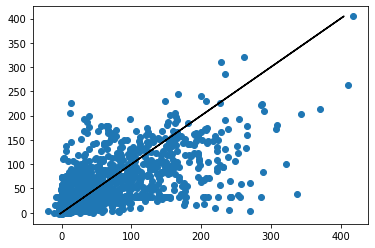

MAE: 33.1
RMSE: 48.8
R^2: 0.41


In [4]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

m = neighbors.KNeighborsRegressor()
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

#### GridSearchCV

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.2min finished


{'metric': 'euclidean', 'n_neighbors': 38, 'weights': 'distance'}


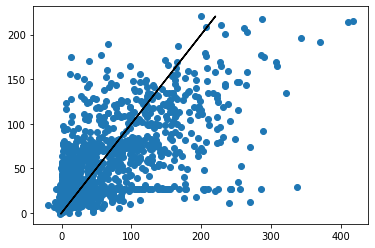

MAE: 31.6
RMSE: 47.4
R^2: 0.45


,param_weights,param_metric,param_n_neighbors,mean_test_score,std_test_score,rank_test_score,mean_fit_time,mean_score_time,std_fit_time,std_score_time
12,distance,euclidean,35,0.450,0.012,10,0.841,2.641,0.037,0.911
14,distance,euclidean,36,0.450,0.011,9,1.680,2.250,0.705,0.222
16,distance,euclidean,37,0.451,0.011,8,1.459,3.091,0.282,0.418
18,distance,euclidean,38,0.454,0.011,1,1.873,3.188,0.512,1.096
20,distance,euclidean,39,0.453,0.011,2,1.435,2.488,0.403,0.434
22,distance,euclidean,40,0.453,0.011,3,1.167,2.061,0.137,0.227
0,distance,manhattan,35,0.448,0.012,17,0.611,2.860,0.055,0.321
2,distance,manhattan,36,0.448,0.013,19,0.922,3.120,0.179,0.467
4,distance,manhattan,37,0.448,0.012,18,0.997,2.866,0.159,0.507
6,distance,manhattan,38,0.451,0.012,6,1.015,2.858,0.217,0.451


In [5]:
X_train, X_dev, y_train, y_dev = X_train_raw, X_dev_raw, y_train, y_dev

params = {
    'weights':['distance','uniform'],
    'metric':['manhattan','euclidean'],
    'n_neighbors':[x for x in range(35,41)],
}

grid = GridSearchCV(
    neighbors.KNeighborsRegressor(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
).fit(X_train,y_train)

print(grid.best_params_)

m = neighbors.KNeighborsRegressor(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

cvGrid(params)

#### GridSearchCV, Standardized

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.2min finished


{'metric': 'euclidean', 'n_neighbors': 36, 'weights': 'distance'}


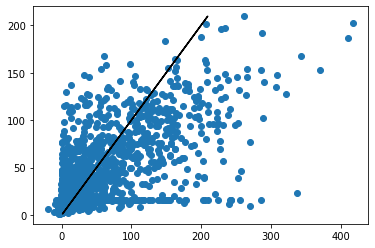

MAE: 30.7
RMSE: 48.8
R^2: 0.41


,param_weights,param_metric,param_n_neighbors,mean_test_score,std_test_score,rank_test_score,mean_fit_time,mean_score_time,std_fit_time,std_score_time
20,distance,euclidean,25,0.429,0.012,40,0.847,5.581,0.018,1.128
21,distance,euclidean,26,0.432,0.011,38,0.868,8.090,0.026,1.635
22,distance,euclidean,27,0.433,0.011,35,1.837,8.990,0.552,3.211
23,distance,euclidean,28,0.434,0.011,32,1.703,9.203,0.485,3.041
24,distance,euclidean,29,0.435,0.010,30,1.768,8.895,0.120,1.870
25,distance,euclidean,30,0.437,0.010,10,1.578,6.950,0.407,0.836
26,distance,euclidean,31,0.436,0.009,16,1.026,6.192,0.432,0.995
27,distance,euclidean,32,0.437,0.009,8,0.841,5.886,0.083,1.098
28,distance,euclidean,33,0.437,0.009,7,0.873,5.477,0.044,0.987
29,distance,euclidean,34,0.437,0.009,11,0.719,4.980,0.119,0.954


In [6]:
X_train, X_dev, y_train, y_dev = X_train_std, X_dev_std, y_train, y_dev

params = {
    'weights':['distance'],
    'metric':['manhattan','euclidean'],
    'n_neighbors':[x for x in range(25,45)],
}

grid = GridSearchCV(
    neighbors.KNeighborsRegressor(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
).fit(X_train,y_train)

print(grid.best_params_)

m = neighbors.KNeighborsRegressor(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

cvGrid(params)

#### GridSearchCV, standardized, hand-selected features

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   29.1s finished


{'metric': 'manhattan', 'n_neighbors': 43, 'weights': 'distance'}


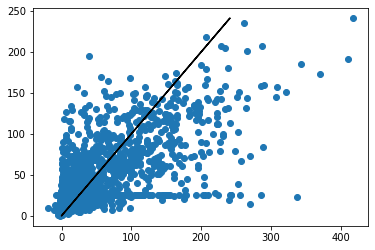

MAE: 31.2
RMSE: 47.2
R^2: 0.45


,param_weights,param_metric,param_n_neighbors,mean_test_score,std_test_score,rank_test_score,mean_fit_time,mean_score_time,std_fit_time,std_score_time
20,distance,euclidean,25,0.450,0.014,30,0.122,0.666,0.010,0.097
21,distance,euclidean,26,0.450,0.014,29,0.112,0.659,0.009,0.051
22,distance,euclidean,27,0.447,0.014,39,0.125,0.679,0.017,0.062
23,distance,euclidean,28,0.448,0.015,36,0.110,0.680,0.011,0.082
24,distance,euclidean,29,0.447,0.015,40,0.113,0.605,0.010,0.109
25,distance,euclidean,30,0.448,0.015,37,0.134,0.695,0.018,0.083
26,distance,euclidean,31,0.448,0.014,35,0.136,0.643,0.019,0.056
27,distance,euclidean,32,0.450,0.010,28,0.150,0.671,0.015,0.107
28,distance,euclidean,33,0.452,0.012,24,0.161,0.655,0.015,0.049
29,distance,euclidean,34,0.452,0.014,20,0.152,0.694,0.017,0.108


In [7]:
X_train, X_dev, y_train, y_dev = X_train_std_select, X_dev_std_select, y_train, y_dev

params = {
    'weights':['distance'],
    'metric':['manhattan','euclidean'],
    'n_neighbors':[x for x in range(25,45)],
}

grid = GridSearchCV(
    neighbors.KNeighborsRegressor(),
    params,
    n_jobs = -1,
    verbose = 7,
    cv = 5
).fit(X_train,y_train)

print(grid.best_params_)

m = neighbors.KNeighborsRegressor(**grid.best_params_)
m.fit(X_train,y_train)
y_pred = m.predict(X_dev)

printStats(y_dev, y_pred)

cvGrid(params)